In [24]:
!pip install datasets
!pip install transformers
!pip install umap-learn

In [ ]:
# import torch
# import pandas as pd
# import numpy as np
# import umap

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [25]:
emotion = load_dataset("emotion")

In [26]:
train_dataset = emotion['train']

In [27]:
print(train_dataset.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [28]:
emotion.set_format(type="pandas")
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [29]:
emotion['train'].features['label'].int2str(1)

'joy'

In [31]:
df['label_name'] = df['label'].apply(label_int2str)

In [32]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


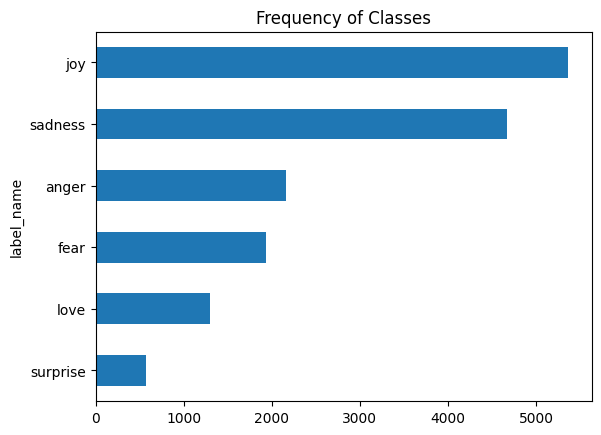

In [33]:
# Class Distribution
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

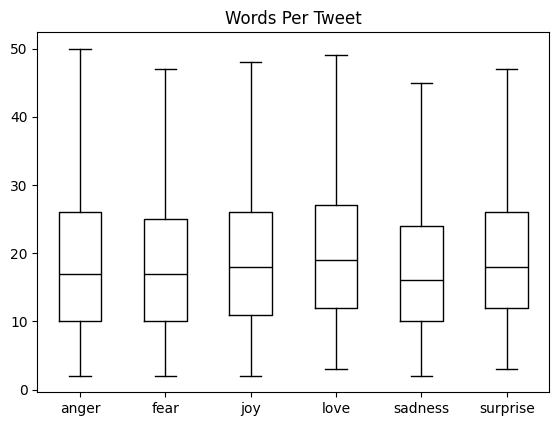

In [34]:
# Words per Tweet
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [35]:
# From the plot we see that for each emotion, most tweets are around 15 words long

In [36]:
# we don’t need the DataFrame format anymore
emotion.reset_format()

In [37]:
# From Text To Tokens - loading the tokenizer for DistilBERT
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [38]:
tokenizer.vocab_size

30522

In [39]:
tokenizer.model_max_length

512

In [40]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [41]:
def tokenize(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

In [42]:
print((tokenize(emotion["train"][:2])))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [43]:
# Special Token
# [PAD] [UNK] [CLS] [SEP] [MASK]
#   0    100   101   102   103

In [69]:
def display_image(src):
    # Load an image (make sure to replace 'image_path' with the actual path to your image)
    img = mpimg.imread(src)

    # Display the image
    plt.imshow(img)

    # Turn off axis labels (optional)
    plt.axis('off')

    # Show the plot with the image
    plt.show()


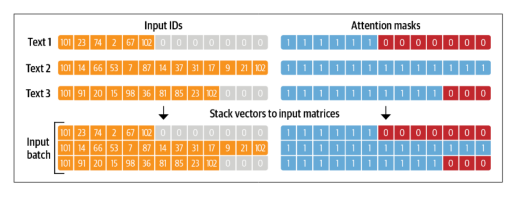

In [ ]:
display_image('images/input.png')

In [45]:
emotions_encoded = emotion.map(tokenize,batched=True,batch_size=None)
# batched=True will encode the tweets in batches.


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [46]:
# First, the text is tokenized and represented as one-hot vectors called token encodings.
# The size of the tokenizer vocabulary determines the dimension of the token encodings
# These token encodings are converted to token embeddings
# The token embeddings are then passed through the encoder block layers to yield a hidden state for each input token
# For the pretraining objective of language modeling
# each hidden state is fed to a layer that predicts the masked input tokens.
# For the classification task, we replace the language modeling layer with a classification layer.

In [47]:
# Models like DistilBERT are pretrained to predict masked words in a sequence of text.

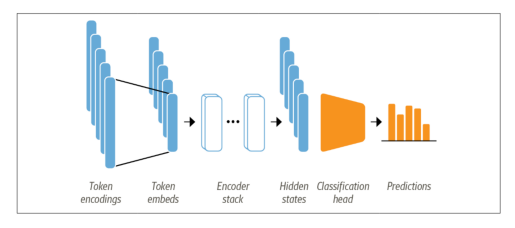

In [ ]:
# The architecture used for sequence classification with an encoder-based transformer; it consists of the model’s pretrained body combined with a custom classifi‐ cation head

display_image('images/model.png')


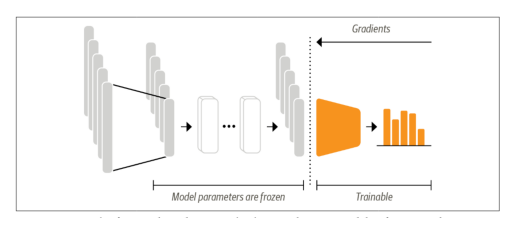

In [ ]:
# Feature extraction We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
# Fine-tuning We train the whole model end-to-end, which also updates the parameters of the pretrained model.
display_image('images/classifier.png')


In [50]:
# AutoModel has a from_pretrained() method to load the weights of a pretrained mode

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [53]:
text = "this is a test"
inputs = tokenizer(text,return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [54]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
    if k in tokenizer.model_input_names}
    # extract last hidden states
    with torch.no_grad() :
      last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state":last_hidden_state[:,0].cpu().numpy()}

In [55]:
# Our model expects tensors as inputs, the next thing to do is convert the input_ids and attention_mask columns to the "torch" format
emotions_encoded.set_format("torch",columns=["input_ids","attention_mask","label"])

In [56]:
emotions_hidden = emotions_encoded.map(extract_hidden_states,batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [57]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [74]:
# Creating a feature matrix

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden["validation"]['label'])

X_train.shape,X_valid.shape

((16000, 768), (2000, 768))

In [59]:
!pip install umap-learn

In [60]:
# Visualizing the training set
# UMAP algorithm to project the vectors down to 2D.
# Since UMAP works best when the features are scaled to lie in the [0,1] interval,


# Scale the features to [0, 1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize UMAP reducer with 2 components and cosine distance metric
reducer = umap.UMAP(n_components=2, metric="cosine")

# Fit UMAP to the scaled data
mapper = reducer.fit(X_scaled)

# Create a DataFrame with 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

# Show the first few rows of the DataFrame
df_emb.head()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.020716,6.421284,0
1,-3.332522,5.263355,0
2,5.006050,3.142964,3
3,-2.471898,3.082005,2
4,-3.387457,3.222010,3


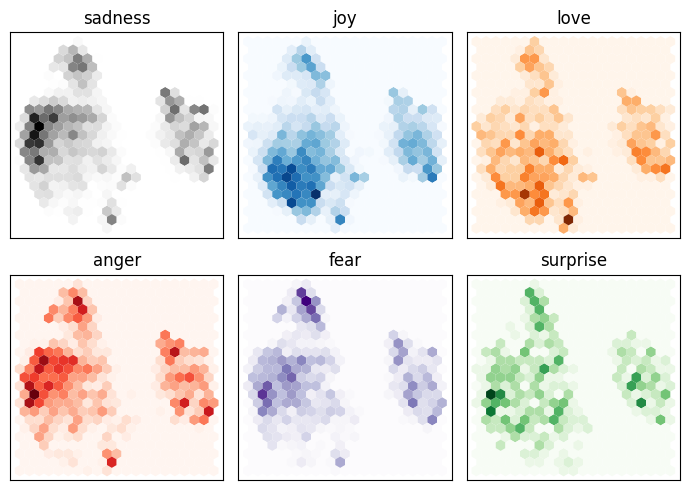

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotion["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
      gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [65]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)
lr_clf.score(X_valid,y_valid)

0.635

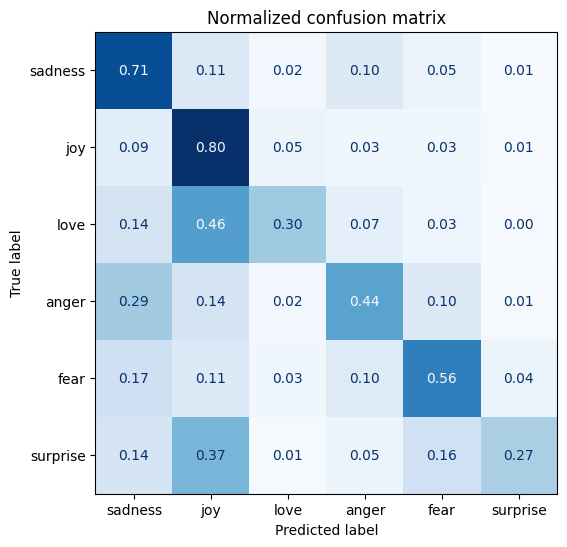

In [66]:

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)